In [1]:
import numpy as np
import warnings
import yadism
from yadbox.export import dump_pineappl_to_file
from eko import interpolation
import lhapdf
import pineappl
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Settings
methods = ["ele","da","jb","sig","esig"]
method = "ele"
eBeam = 5
pBeam = 41
beamConfig = f"{eBeam}x{pBeam}"
binning = 'StandardBinning' # 'HeraBinning' or 'StandardBinning'
lumi = 10. # Used to select table with the intended luminosity

# Load dataframe for desired config
data = pd.read_csv(f"../Tables/{binning}_{method}_Ee{eBeam}_Ep{pBeam}_lumi{lumi}fb-1_bins.csv")

In [3]:
data

,Q2,x,y,gen,rec,gen_rec,purity,stability
0,1.258925,0.001995,0.769460,4.634915e+07,3.107802e+07,2.826037e+07,0.909336,0.609728
1,1.258925,0.003162,0.485497,7.481432e+07,6.668335e+07,5.475309e+07,0.821091,0.731853
2,1.258925,0.005012,0.306328,9.214961e+07,9.735445e+07,6.993744e+07,0.718379,0.758955
3,1.258925,0.007943,0.193280,1.118488e+08,1.168375e+08,7.879675e+07,0.674413,0.704494
4,1.258925,0.012589,0.121951,1.247757e+08,1.311817e+08,7.351524e+07,0.560408,0.589179
...,...,...,...,...,...,...,...,...
94,199.526231,0.501187,0.485497,1.841277e+05,1.344364e+05,1.271453e+05,0.945765,0.690528
95,199.526231,0.794328,0.306328,1.951199e+04,1.631456e+04,1.314721e+04,0.805857,0.673801
96,316.227766,0.501187,0.769460,9.393487e+04,6.303643e+04,6.094156e+04,0.966767,0.648764
97,316.227766,0.794328,0.485497,1.030728e+04,7.570084e+03,6.030675e+03,0.796646,0.585089


In [4]:
theory_card = {
    # QCD perturbative order
    "PTO": 2,  # perturbative order in alpha_s: 0 = LO (alpha_s^0), 1 = NLO (alpha_s^1) ...

    # SM parameters and masses
    "CKM": "0.97428 0.22530 0.003470 0.22520 0.97345 0.041000 0.00862 0.04030 0.999152",  # CKM matrix elements
    "GF": 1.1663787e-05,  # [GeV^-2] Fermi coupling constant
    "MP": 0.938,  # [GeV] proton mass
    "MW": 80.398,  # [GeV] W boson mass
    "MZ": 91.1876,  # [GeV] Z boson mass
    "alphaqed": 0.007496252,  # alpha_em value
    "kcThr": 1.0,  # ratio of the charm matching scale over the charm mass
    "kbThr": 1.0,  # ratio of the bottom matching scale over the bottom mass
    "ktThr": 1.0,  # ratio of the top matching scale over the top mass
    "mc": 1.51,  # [GeV] charm mass
    "mb": 4.92,  # [GeV] bottom mass
    "mt": 172.5,  # [GeV] top mass

    # Flavor number scheme settings
    "FNS": "FONLL-FFNS",  # Flavour Number Scheme, options: "FFNS", "FFN0", "ZM-VFNS"
    "NfFF": 4,  # (fixed) number of running flavors, only for FFNS or FFN0 schemes
    "Q0": 1.65,  # [GeV] reference scale for the flavor patch determination
    "nf0": 4,  # number of active flavors at the Q0 reference scale

    # Alphas settings and boundary conditions
    "Qref": 91.2,  # [GeV] reference scale for the alphas value
    "nfref": 5,  # number of active flavors at the reference scale Qref
    "alphas": 0.118,  # alphas value at the reference scale
    "MaxNfAs": 5,  # maximum number of flavors in running of strong coupling
    "QED": 0,  # QED correction to running of strong coupling: 0 = disabled, 1 = allowed

    # Scale Variations
    "XIF": 1.0,  # ratio of factorization scale over the hard scattering scale
    "XIR": 1.0,  # ratio of renormalization scale over the hard scattering scale

    # Other settings
    "IC": 0,  # 0 = perturbative charm only, 1 = intrinsic charm allowed
    "TMC": 1,  # include target mass corrections: 0 = disabled, 1 = leading twist, 2 = higher twist approximated, 3 = higher twist exact
    "n3lo_cf_variation": 0,  # N3LO coefficient functions variation: -1 = lower bound, 0 = central , 1 = upper bound

    # Other EKO settings, not relevant for Yadism
    "HQ": "POLE",  # heavy quark mass scheme (not yet implemented in yadism)
    "MaxNfPdf": 5,  # maximum number of flavors in running of PDFs (ignored by yadism)
    "ModEv": "EXA",  # evolution solver for PDFs (ignored by yadism)
}

In [5]:
observables_card = {
    "PolarizationDIS": 0.0,
    "ProjectileDIS": "electron",
    "PropagatorCorrection": 0.0,
    "TargetDIS": "proton",
    "interpolation_is_log": True,
    "interpolation_polynomial_degree": 4,
    "interpolation_xgrid": interpolation.lambertgrid(60).tolist(),
    "observables": {"XSHERANC_total": []},
    "prDIS": "NC",
    "NCPositivityCharge": None,
}

In [6]:
def compute_predictions() -> None:
    """Compute yadism prediction for all experimental bins."""
    # prepare the kinematics for all the datapoints
    curobs = data.apply(
        lambda dat: {"x": dat["x"], "Q2": dat["Q2"], "y": dat["y"]},
        axis=1,
    )

    # Update the observable & kinematics in the `observable_card`
    obs_def = {
        "observables" : {"XSHERANC_total": list(curobs.to_dict().values())}
    } # As we saw in the previous tutorial, it has to be a dict[dict[list]]
    observables_card.update(obs_def)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # suppress noisy warnings
        out = yadism.run_yadism(theory_card, observables_card)

    # Save results to a PineAPPL grid
    #dump_pineappl_to_file(out, "Yadism_Predictions.pineappl.lz4", "XSHERANC_total")
    dump_pineappl_to_file(out, f"../PineAPPL_grids/Xsec_Predictions_ep_Ee{eBeam}_Ep{pBeam}.{binning}.pineappl.lz4", "XSHERANC_total")

In [7]:
# ONLY RUN IF GRID DOESN'T ALREADY EXIST IN ../PineAPPL_grids
compute_predictions() 

┌────────────────────────────────────┐                                       
                                      │                                    │                                       
                                      │ __     __       _ _                │                                       
                                      │ \ \   / /      | (_)               │                                       
                                      │  \ \_/ /_ _  __| |_ ___ _ __ ___   │                                       
                                      │   \   / _` |/ _` | / __| '_ ` _ \  │                                       
                                      │    | | (_| | (_| | \__ \ | | | | | │                                       
                                      │    |_|\__,_|\__,_|_|___/_| |_| |_| │                                       
                                      │                                    │                                       
                                      └────────────────────────────────────┘

Plan

 • XSHERANC_total at 99 pts

Calculation

yadism took off! please stay tuned ...

Output()

[22:53:54] INFO     computing P_qq_0 - took: 0.346062 s                                      ]8;id=851750;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=854719;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[22:53:55] INFO     computing P_qg_0 - took: 0.348205 s                                      ]8;id=215610;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=438582;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

           INFO     computing P_gq_0 - took: 0.311166 s                                      ]8;id=246341;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=530694;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

           INFO     computing P_gg_0 - took: 0.473401 s                                      ]8;id=325956;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=433737;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[22:53:56] INFO     computing P_qq_1 - took: 0.609756 s                                      ]8;id=767919;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=127097;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

           INFO     computing P_qg_1 - took: 0.433481 s                                      ]8;id=561018;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=453551;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[22:53:57] INFO     computing P_nsp_1 - took: 0.564384 s                                     ]8;id=140327;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=287092;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[22:53:58] INFO     computing P_nsm_1 - took: 0.537268 s                                     ]8;id=178882;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=55429;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

           INFO     computing P_qq_0^2 - took: 0.643633 s                                    ]8;id=804413;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=245835;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[22:53:59] INFO     computing P_qg_0P_gq_0 - took: 0.343222 s                                ]8;id=637597;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=449925;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

           INFO     computing P_qq_0P_qg_0 - took: 0.415327 s                                ]8;id=844458;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=829035;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

           INFO     computing P_qg_0P_gg_0 - took: 0.442630 s                                ]8;id=499241;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py\scale_variations.py]8;;\:]8;id=734696;file:///home/stephen/Programs/yadism/.venv/lib/python3.11/site-packages/yadism/esf/scale_variations.py#85\85]8;;\
Starting... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

took 192.70 s

In [8]:
data

,Q2,x,y,gen,rec,gen_rec,purity,stability
0,1.258925,0.001995,0.769460,4.634915e+07,3.107802e+07,2.826037e+07,0.909336,0.609728
1,1.258925,0.003162,0.485497,7.481432e+07,6.668335e+07,5.475309e+07,0.821091,0.731853
2,1.258925,0.005012,0.306328,9.214961e+07,9.735445e+07,6.993744e+07,0.718379,0.758955
3,1.258925,0.007943,0.193280,1.118488e+08,1.168375e+08,7.879675e+07,0.674413,0.704494
4,1.258925,0.012589,0.121951,1.247757e+08,1.311817e+08,7.351524e+07,0.560408,0.589179
...,...,...,...,...,...,...,...,...
94,199.526231,0.501187,0.485497,1.841277e+05,1.344364e+05,1.271453e+05,0.945765,0.690528
95,199.526231,0.794328,0.306328,1.951199e+04,1.631456e+04,1.314721e+04,0.805857,0.673801
96,316.227766,0.501187,0.769460,9.393487e+04,6.303643e+04,6.094156e+04,0.966767,0.648764
97,316.227766,0.794328,0.485497,1.030728e+04,7.570084e+03,6.030675e+03,0.796646,0.585089


LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0000.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #0, version 1; LHAPDF ID = 316900
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0001.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #1, version 1; LHAPDF ID = 316901
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0002.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #2, version 1; LHAPDF ID = 316902
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0003.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #3, version 1; LHAPDF ID = 316903
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0004.dat
NNPDF31_nnlo_as_0118_proton PDF set, m

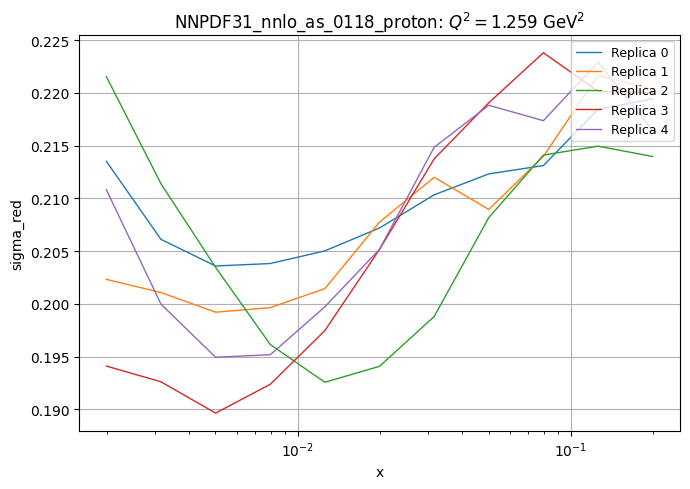

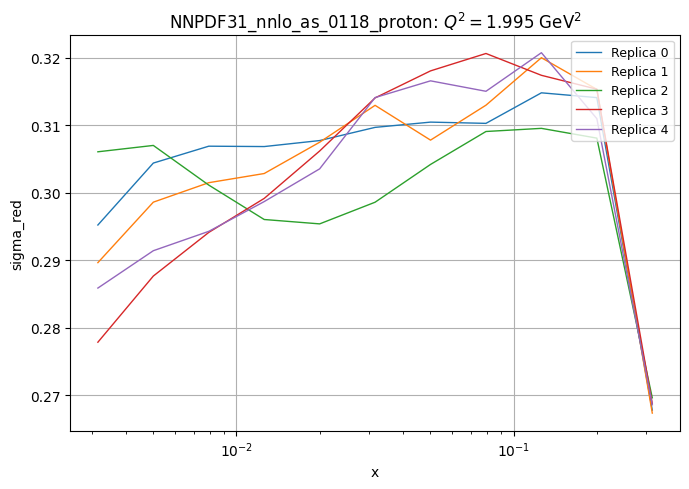

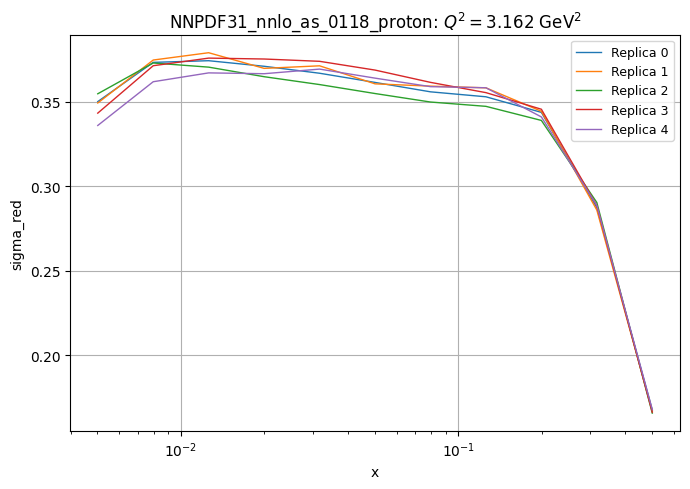

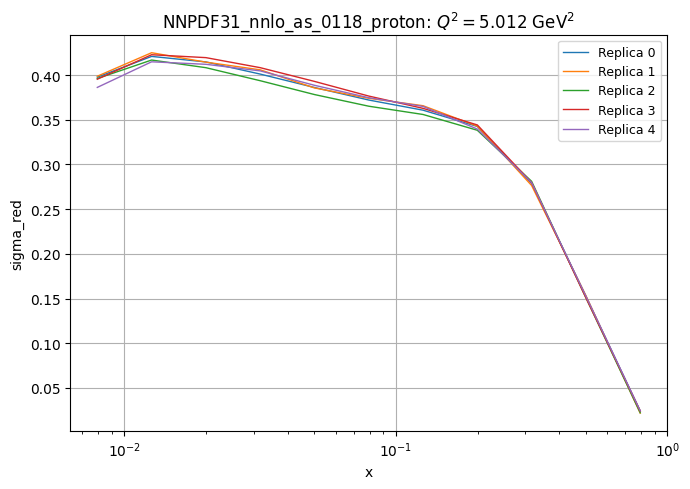

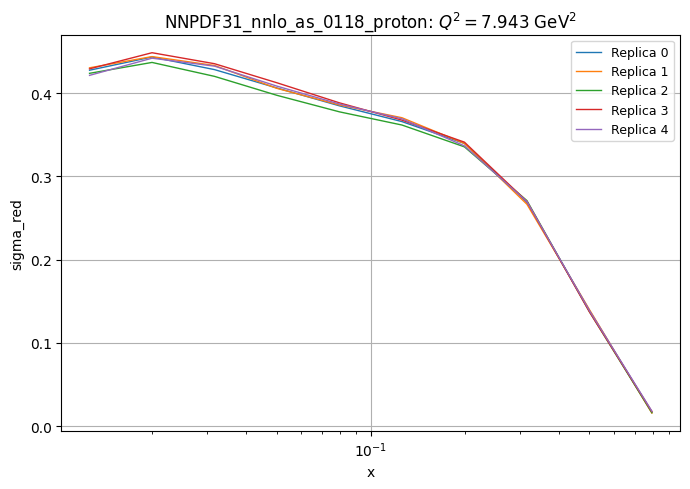

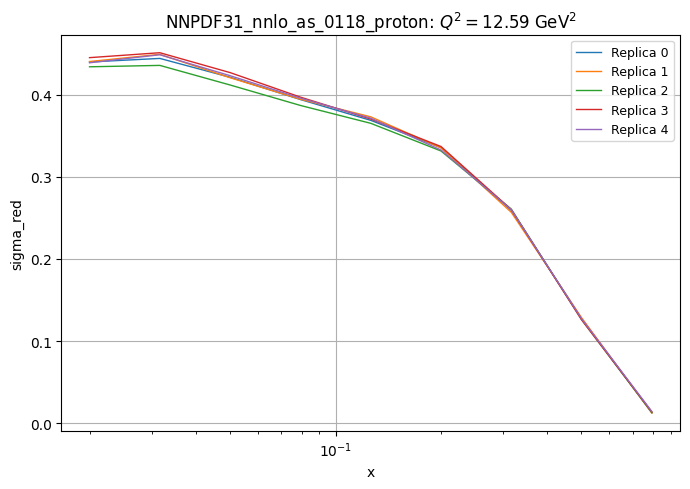

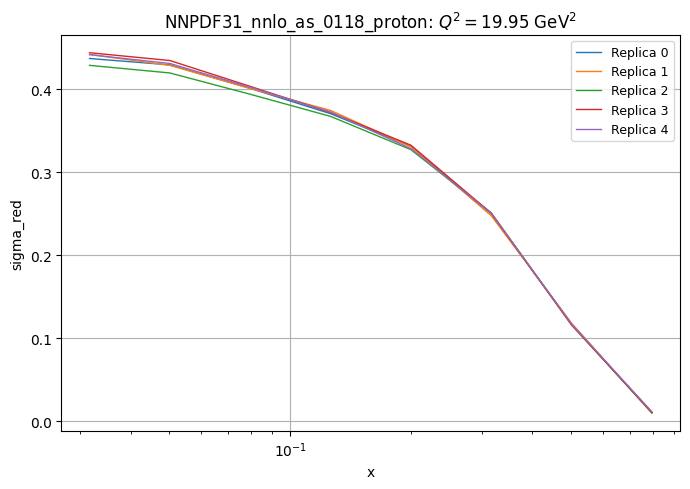

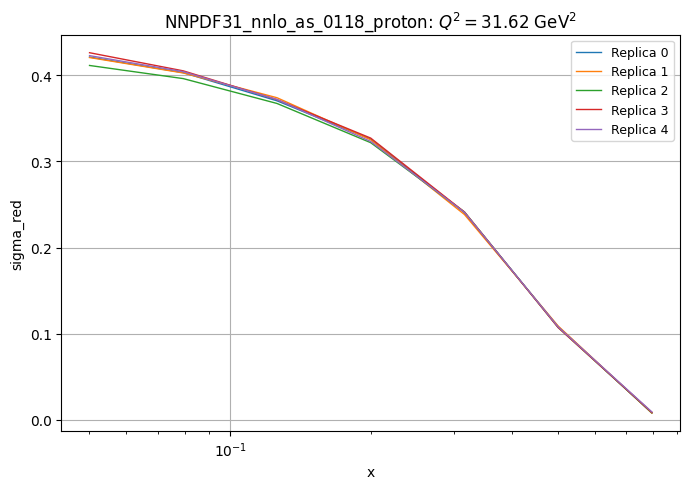

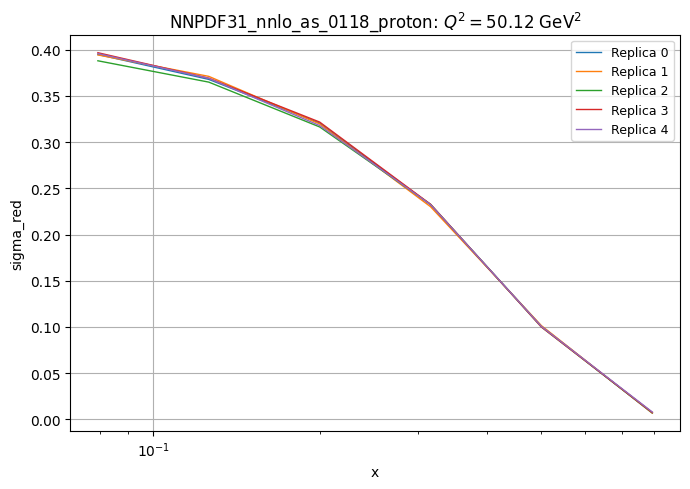

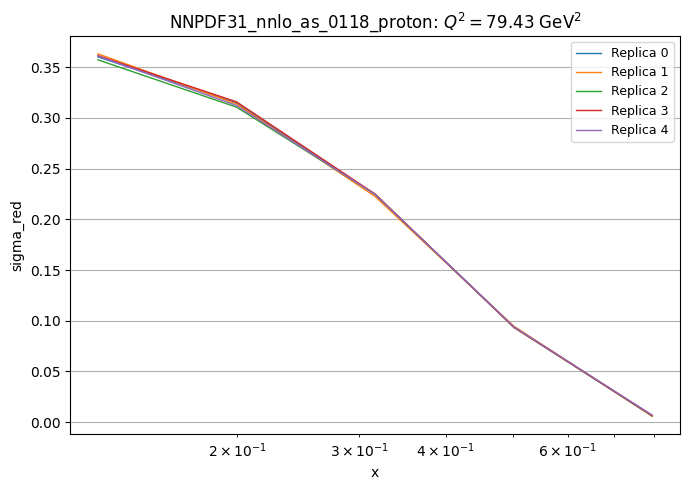

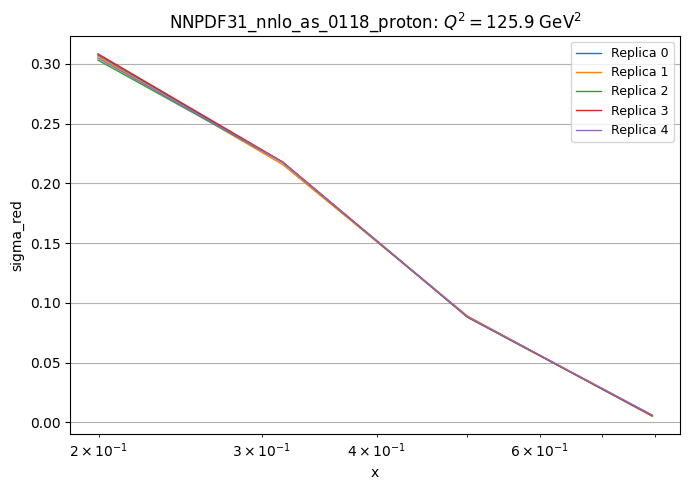

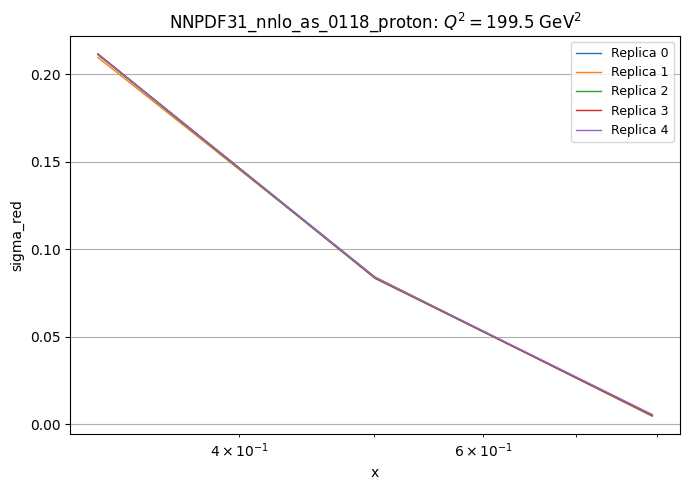

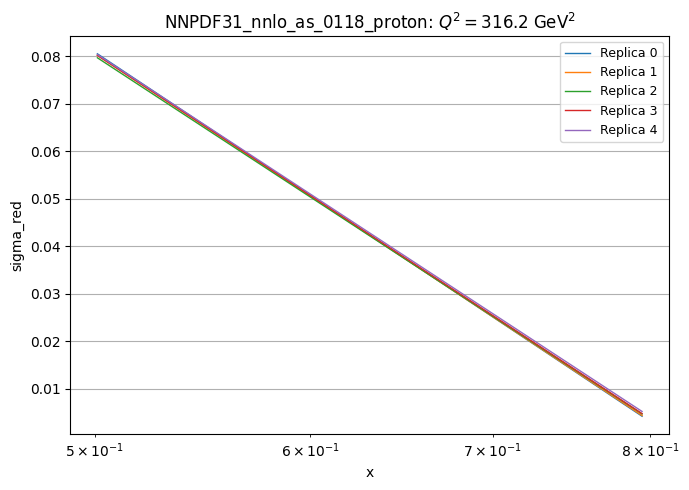

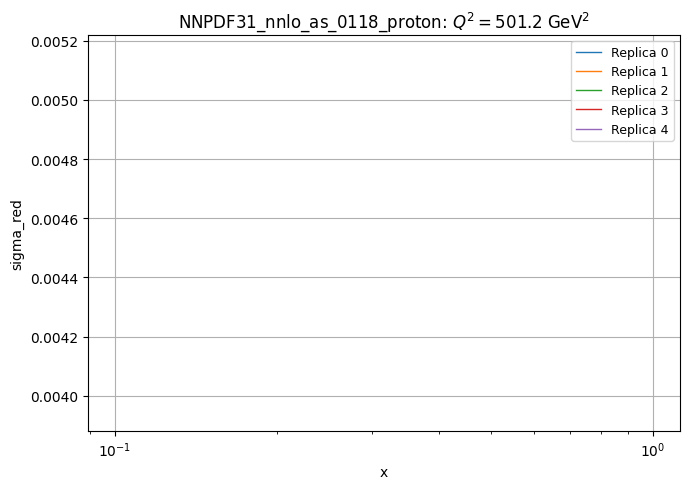

In [9]:
# Load the pre-computed grid
grid = pineappl.grid.Grid.read(f"../PineAPPL_grids/Xsec_Predictions_ep_Ee{eBeam}_Ep{pBeam}.{binning}.pineappl.lz4")

pdfset = "NNPDF31_nnlo_as_0118_proton"
# pdfset = "HERAPDF20_NNLO_EIG" # Don't use here - require eigenvector errors

# Convolve with the PDF for the central member
pdf = lhapdf.mkPDF(pdfset, 0)
yadism_data = grid.convolve_with_one(2212, pdf.xfxQ2, pdf.alphasQ2)

yadism_df = pd.concat(
    [
        data["Q2"],
        data["x"],
        data["y"],
        pd.DataFrame([yadism_data], index=["sigma_red_0"]).T,
    ],
    axis=1,
)
#yadism_df[["Q2", "x", "y", "sigma_red_0"]].to_csv(f"../Tables/{pdfset}_Ee{eBeam}_Ep{pBeam}_replica_0_Xsec.csv")

# Add data for 15 replicas
num_replicas = 5
for replica_index in range(1, num_replicas):
    # Redefine the PDF for each replica
    pdf = lhapdf.mkPDF(pdfset, replica_index)
    
    # Convolve with the Yadism grid again
    yadism_data = grid.convolve_with_one(2212, pdf.xfxQ2, pdf.alphasQ2)
    
    # Add the replica's data to the DataFrame
    yadism_df[f"sigma_red_{replica_index}"] = yadism_data

def plot_comparisons_q2(df: pd.DataFrame, q2_value: float = 139) -> None:
    """Plot Yadism predictions for multiple replicas."""
    fig, ax = plt.subplots(figsize=(7, 5), layout="tight")
    
    # Select corresponding Q2 values
    df_q2 = df[np.isclose(df['Q2'], q2_value, atol=0.01)]

    # Plot each replica as a line
    for replica_index in range(num_replicas):
        ax.plot(df_q2.x, df_q2[f"sigma_red_{replica_index}"], label=f"Replica {replica_index}", linestyle='-', linewidth=1)

    ax.set_xlabel("x")
    ax.set_ylabel("sigma_red")
    ax.legend(loc='upper right', fontsize=9)
    ax.set_xscale("log")
    ax.set_title(f"{pdfset}: $Q^2 = {q2_value:.4g}~ \\mathrm{{GeV}}^2$")
    ax.grid(True)

    plt.savefig(f"../Plots/{pdfset}_Xsec_ep_Ee{eBeam}_Ep{pBeam}.{binning}_Q2_{q2_value:.4g}.png")



# Plot for Q^2 = 139 GeV^2
# plot_comparisons_q2(yadism_df, 2.7)
# plot_comparisons_q2(yadism_df, 500.)
#plt.show()

for Q2 in yadism_df['Q2'].unique():
    plot_comparisons_q2(yadism_df, Q2)
plt.show()

In [10]:
yadism_df # yadism_df[:30]

,Q2,x,y,sigma_red_0,sigma_red_1,sigma_red_2,sigma_red_3,sigma_red_4
0,1.258925,0.001995,0.769460,0.213504,0.202315,0.221531,0.194099,0.210811
1,1.258925,0.003162,0.485497,0.206107,0.201067,0.211380,0.192607,0.199964
2,1.258925,0.005012,0.306328,0.203583,0.199203,0.203453,0.189640,0.194933
3,1.258925,0.007943,0.193280,0.203816,0.199635,0.196141,0.192371,0.195173
4,1.258925,0.012589,0.121951,0.205017,0.201440,0.192563,0.197462,0.199719
...,...,...,...,...,...,...,...,...
94,199.526231,0.501187,0.485497,0.084016,0.083983,0.083259,0.083532,0.083757
95,199.526231,0.794328,0.306328,0.004552,0.004656,0.005040,0.005106,0.005494
96,316.227766,0.501187,0.769460,0.080542,0.080219,0.079708,0.080213,0.080395
97,316.227766,0.794328,0.485497,0.004164,0.004313,0.004644,0.004709,0.005164


LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0000.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #0, version 1; LHAPDF ID = 316900
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0001.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #1, version 1; LHAPDF ID = 316901
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0002.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #2, version 1; LHAPDF ID = 316902
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0003.dat
NNPDF31_nnlo_as_0118_proton PDF set, member #3, version 1; LHAPDF ID = 316903
LHAPDF 6.5.5 loading /home/stephen/Programs/install/share/LHAPDF/NNPDF31_nnlo_as_0118_proton/NNPDF31_nnlo_as_0118_proton_0004.dat
NNPDF31_nnlo_as_0118_proton PDF set, m

/tmp/ipykernel_24021/1844897936.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  yadism_df[f"sigma_red_{replica_index}"] = yadism_data
/tmp/ipykernel_24021/1844897936.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  yadism_df[f"sigma_red_{replica_index}"] = yadism_data
/tmp/ipykernel_24021/1844897936.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

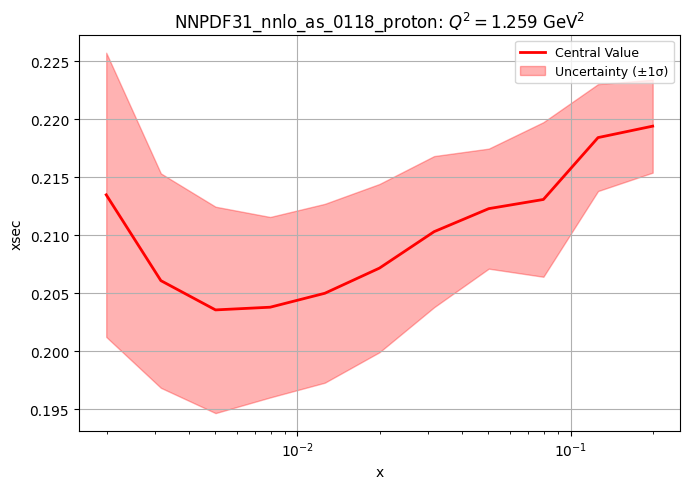

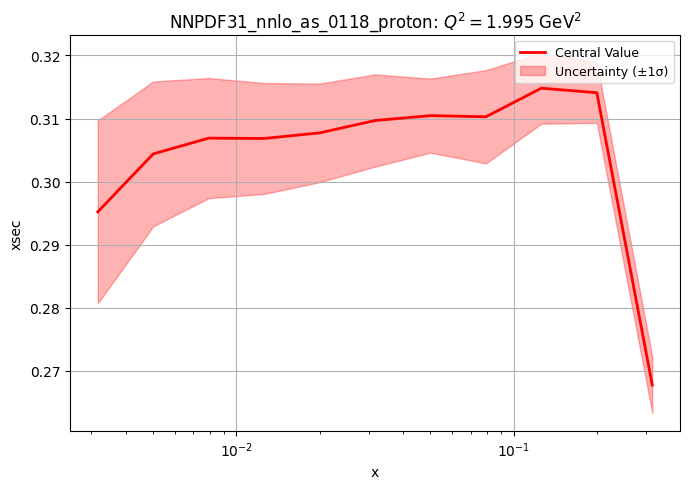

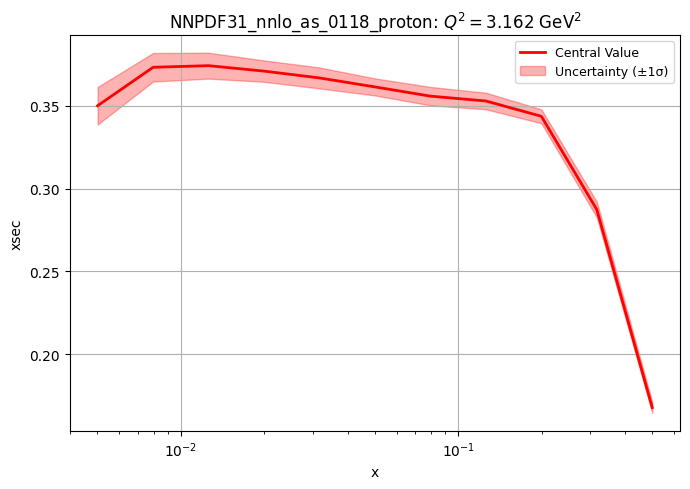

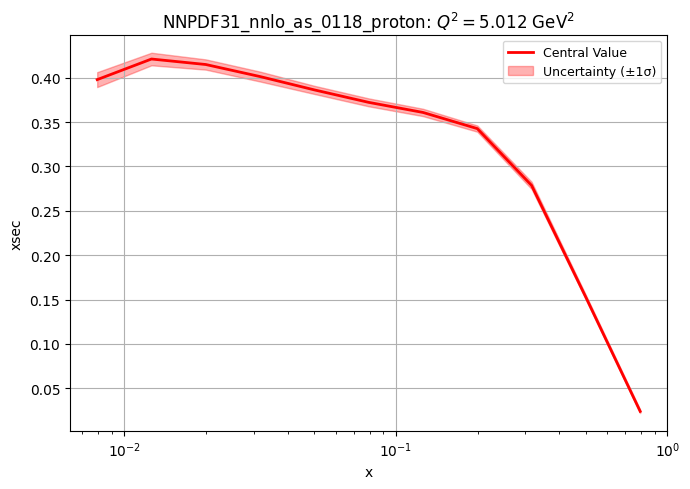

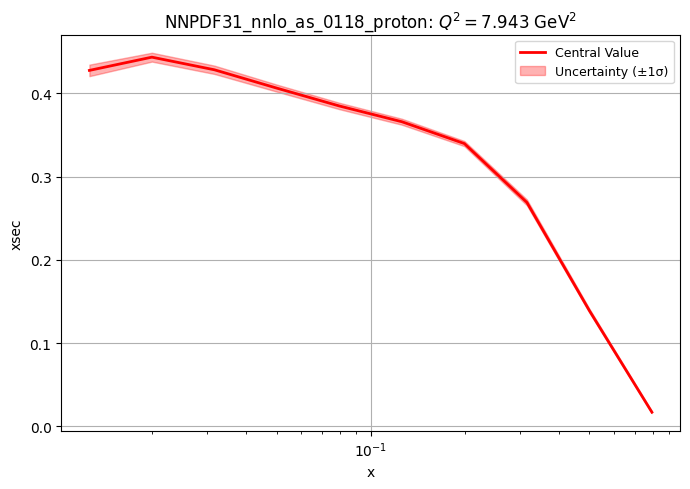

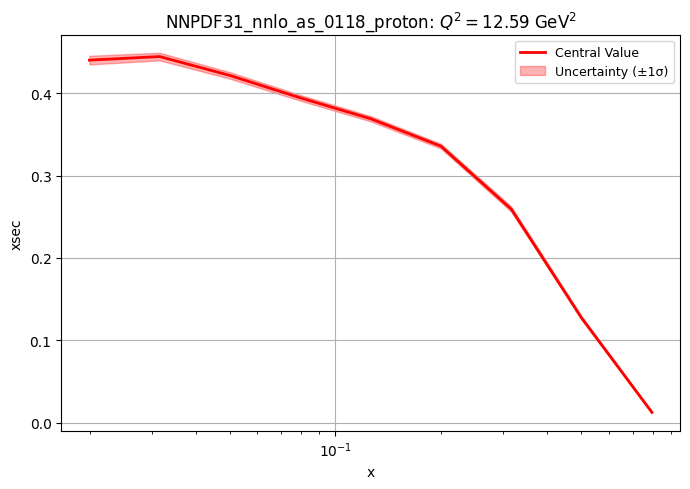

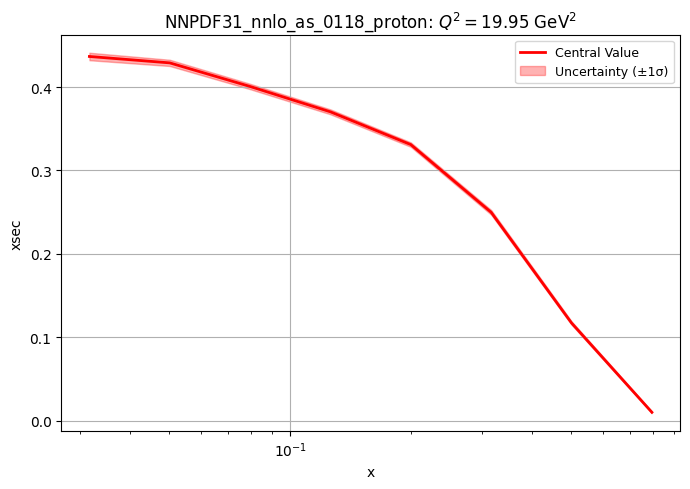

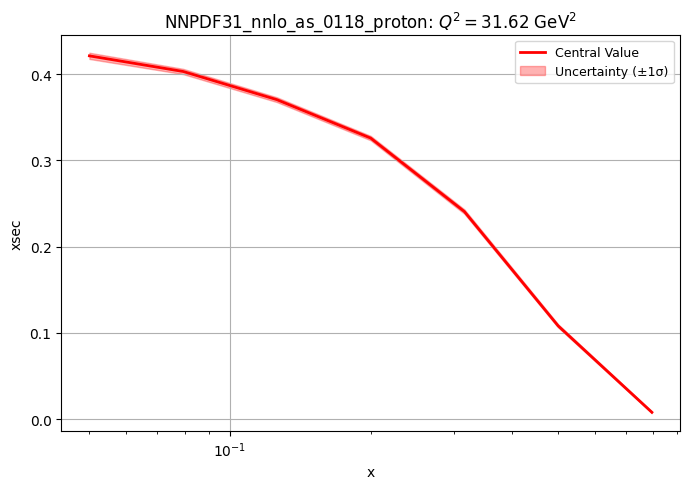

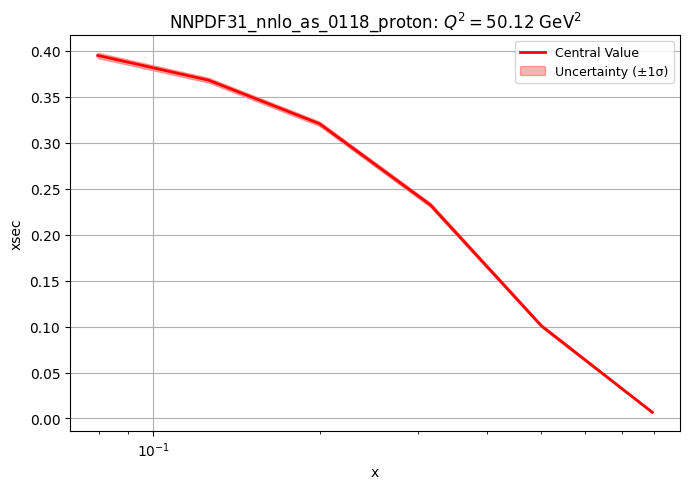

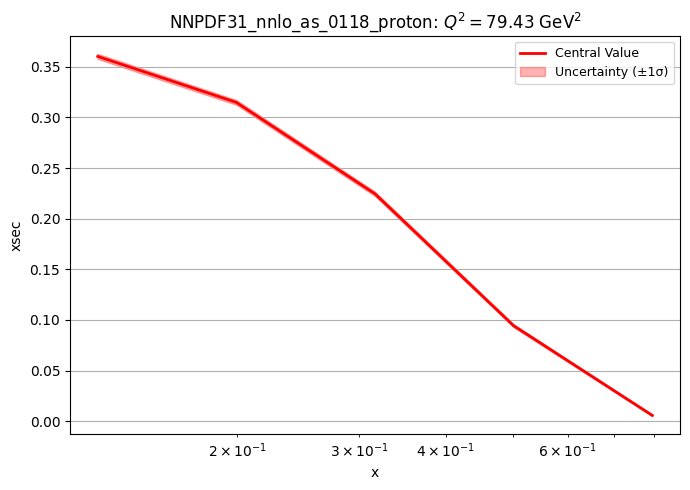

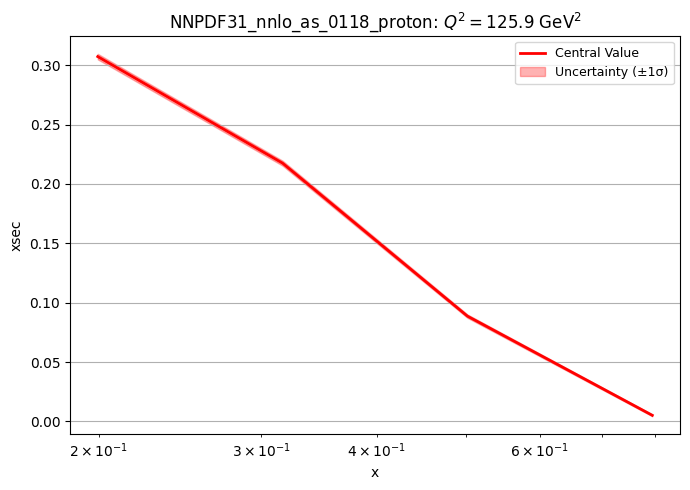

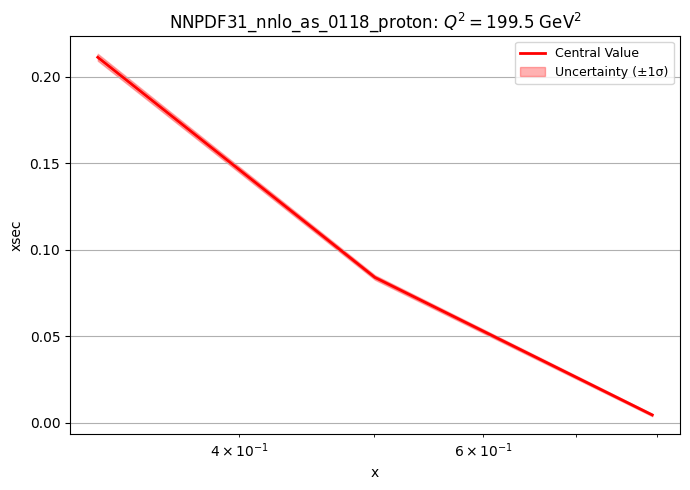

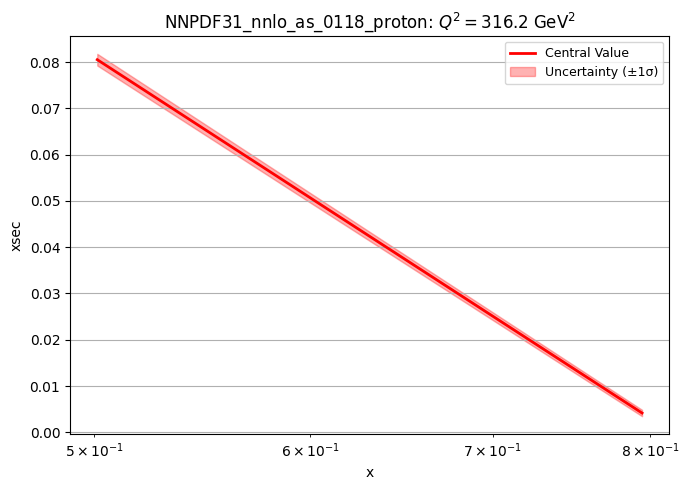

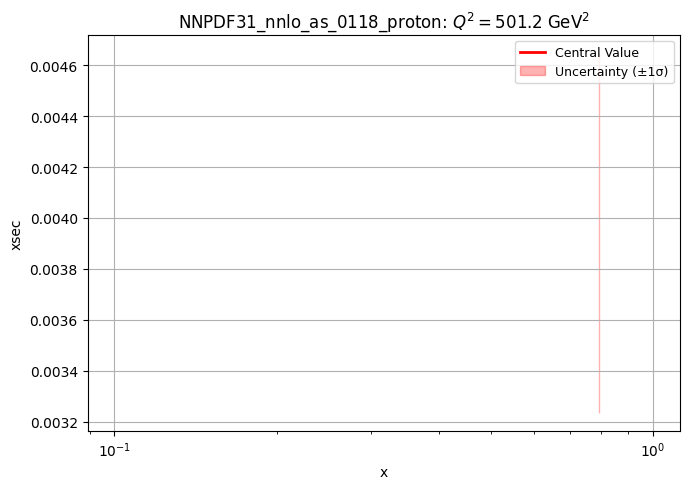

In [11]:
# TODO: Fix PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times
# Will likely require changing how I manage the df

# Load the pre-computed grid
grid = pineappl.grid.Grid.read(f"../PineAPPL_grids/Xsec_Predictions_ep_Ee{eBeam}_Ep{pBeam}.{binning}.pineappl.lz4")

# Set PDF set
pdfset = "NNPDF31_nnlo_as_0118_proton"

# Number of replicas
num_replicas = 5

if ("NNPDF" in pdfset):
    error_type = "mc_replica"
    num_replicas = 100


# Initialise DataFrame with central value (replica 0)
pdf = lhapdf.mkPDF(pdfset, 0)
yadism_data = grid.convolve_with_one(2212, pdf.xfxQ2, pdf.alphasQ2)

yadism_df = pd.concat(
    [
        data["Q2"],
        data["x"],
        data["y"],
        pd.DataFrame([yadism_data], index=["sigma_red_0"]).T,
    ],
    axis=1,
)

# Add data for remaining replicas
for replica_index in range(1, num_replicas):
    pdf = lhapdf.mkPDF(pdfset, replica_index)
    yadism_data = grid.convolve_with_one(2212, pdf.xfxQ2, pdf.alphasQ2)
    yadism_df[f"sigma_red_{replica_index}"] = yadism_data

# Compute standard deviation across all replicas (uncertainty)
replica_columns = [f"sigma_red_{i}" for i in range(1, num_replicas)]  # Excluding central value

if (error_type == "mc_replica"):
    yadism_df["sigma_red_unc"] = yadism_df[replica_columns].std(axis=1, ddof=1)  # Sample standard deviation

print(f"Using {error_type} approach for errors")

# Define function for plotting w/ error bands
def plot_expectation_q2(df: pd.DataFrame, q2_value: float = 139) -> None:
    """Plot central value with uncertainty for a given Q² value."""
    fig, ax = plt.subplots(figsize=(7, 5), layout="tight")

    # Select corresponding Q2 values
    df_q2 = df[np.isclose(df['Q2'], q2_value, atol=0.01)]

    # Plot central value
    ax.plot(df_q2.x, df_q2["sigma_red_0"], label="Central Value", color="r", linestyle="-", linewidth=2)

    # Plot shaded uncertainty region
    ax.fill_between(df_q2.x, df_q2["sigma_red_0"] - df_q2["sigma_red_unc"], 
                                df_q2["sigma_red_0"] + df_q2["sigma_red_unc"], 
                    color="r", alpha=0.3, label="Uncertainty (±1σ)")

    ax.set_xlabel("x")
    ax.set_ylabel("xsec")
    ax.set_xscale("log")
    ax.set_title(f"{pdfset}: $Q^2 = {q2_value:.4g}~ \\mathrm{{GeV}}^2$")
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True)

    plt.savefig(f"../Plots/{pdfset}_Xsec_ep_Ee{eBeam}_Ep{pBeam}.{binning}_Q2_{q2_value:.4g}.png")

# Plot for Q^2 = 10^0.7 and 10^2.3
# plot_expectation_q2(yadism_df, 2.0)
# plot_expectation_q2(yadism_df, 500.)
# plt.show()

for Q2 in data['Q2'].unique():
    plot_expectation_q2(yadism_df, Q2)
plt.show()

In [12]:
yadism_df

,Q2,x,y,sigma_red_0,sigma_red_1,sigma_red_2,sigma_red_3,sigma_red_4,sigma_red_5,sigma_red_6,...,sigma_red_91,sigma_red_92,sigma_red_93,sigma_red_94,sigma_red_95,sigma_red_96,sigma_red_97,sigma_red_98,sigma_red_99,sigma_red_unc
0,1.258925,0.001995,0.769460,0.213504,0.202315,0.221531,0.194099,0.210811,0.192947,0.221801,...,0.216031,0.220015,0.217299,0.209253,0.160025,0.199024,0.221858,0.210775,0.207554,0.012251
1,1.258925,0.003162,0.485497,0.206107,0.201067,0.211380,0.192607,0.199964,0.180266,0.210261,...,0.206235,0.209846,0.204903,0.192710,0.177001,0.192447,0.218927,0.205951,0.202492,0.009242
2,1.258925,0.005012,0.306328,0.203583,0.199203,0.203453,0.189640,0.194933,0.180112,0.205136,...,0.200479,0.203097,0.197735,0.190767,0.186468,0.193832,0.216184,0.202109,0.207333,0.008896
3,1.258925,0.007943,0.193280,0.203816,0.199635,0.196141,0.192371,0.195173,0.182400,0.196287,...,0.196893,0.198256,0.191432,0.193756,0.194560,0.198430,0.213668,0.198955,0.205556,0.007778
4,1.258925,0.012589,0.121951,0.205017,0.201440,0.192563,0.197462,0.199719,0.186161,0.196707,...,0.196247,0.199656,0.199452,0.198339,0.199809,0.204342,0.211418,0.196964,0.205708,0.007709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,199.526231,0.501187,0.485497,0.084016,0.083983,0.083259,0.083532,0.083757,0.085562,0.083541,...,0.082575,0.084242,0.085485,0.082171,0.084129,0.083715,0.082908,0.084674,0.083557,0.001317
95,199.526231,0.794328,0.306328,0.004552,0.004656,0.005040,0.005106,0.005494,0.004332,0.005741,...,0.002273,0.004875,0.004227,0.004618,0.004605,0.003004,0.004433,0.004398,0.004537,0.000723
96,316.227766,0.501187,0.769460,0.080542,0.080219,0.079708,0.080213,0.080395,0.081845,0.079930,...,0.078908,0.081137,0.081886,0.078782,0.080685,0.080164,0.079363,0.081009,0.080193,0.001267
97,316.227766,0.794328,0.485497,0.004164,0.004313,0.004644,0.004709,0.005164,0.003878,0.005306,...,0.001904,0.004506,0.003857,0.004273,0.004218,0.002704,0.004021,0.004023,0.004124,0.000693


In [13]:
yadism_df[['Q2', 'x', 'y', 'sigma_red_0', 'sigma_red_unc']].to_csv(f"../Tables/{binning}_{method}_Ee{eBeam}_Ep{pBeam}_{pdfset}_XsecPredictions.csv",index=False)

In [14]:
herapdf_df = pd.read_csv(f"../HERAPDF_Xsec_Tables/{binning}/herapdf2nnlo-{eBeam}x{pBeam}",names=['Q2','x','y','sigma_red_0','sigma_red_unc_+','sigma_red_unc_-'],sep='\s+')

FileNotFoundError: [Errno 2] No such file or directory: '../HERAPDF_Xsec_Tables/StandardBinning/herapdf2nnlo-10x100'

In [79]:
herapdf_df

,Q2,x,y,sigma_red_0,sigma_red_unc_+,sigma_red_unc_-
0,3.5,0.0020,0.67308,0.528680,0.006150,0.010319
1,3.5,0.0032,0.42067,0.512800,0.006112,0.009579
2,3.5,0.0050,0.26923,0.487620,0.006207,0.008971
3,3.5,0.0080,0.16827,0.461150,0.006218,0.008162
4,3.5,0.0130,0.10355,0.437260,0.006067,0.007133
...,...,...,...,...,...,...
186,800.0,0.4000,0.76923,0.150300,0.001942,0.002093
187,800.0,0.6500,0.47337,0.020000,0.000691,0.000706
188,1000.0,0.6500,0.59172,0.019828,0.000698,0.000703
189,1200.0,0.6500,0.71006,0.019843,0.000715,0.000707


In [80]:
herapdf_df.to_csv(f"../Tables/{binning}_{method}_Ee{eBeam}_Ep{pBeam}_HERAPDF2_XsecPredictions_AsymErr.csv",index=False)

/tmp/ipykernel_10395/2994205754.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7, 5), layout="tight")


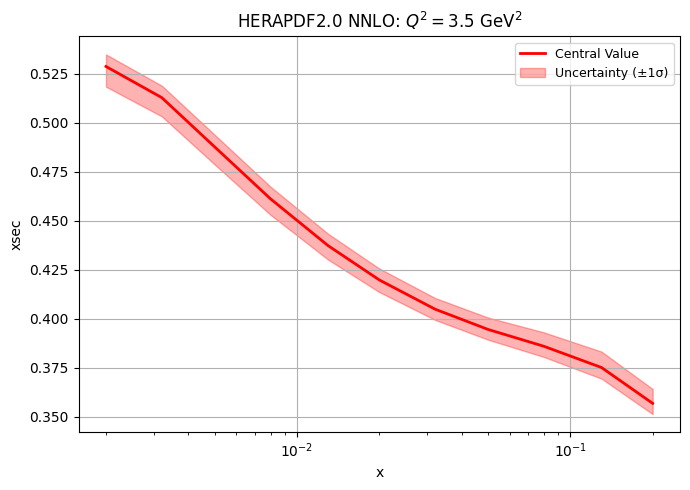

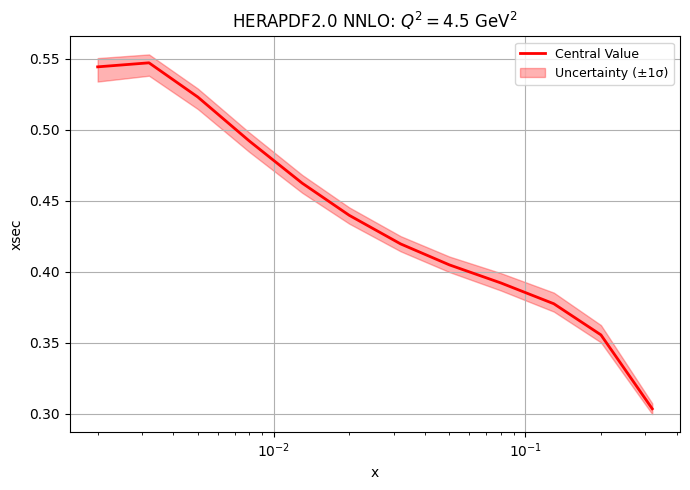

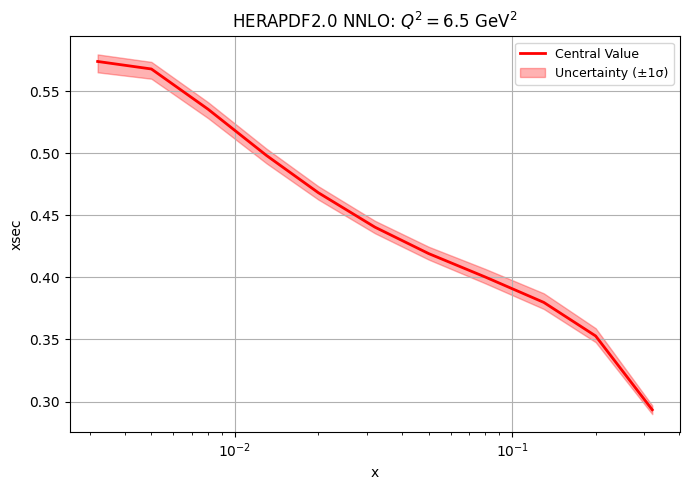

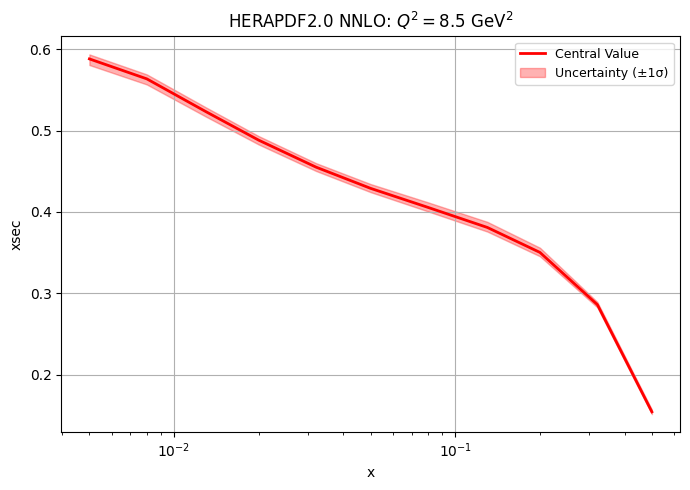

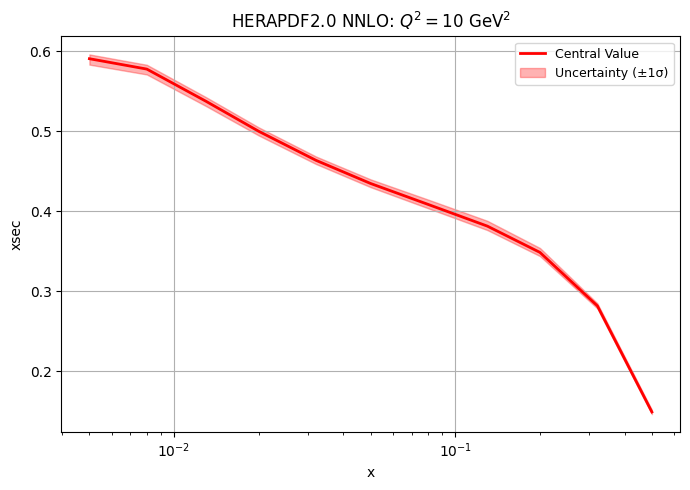

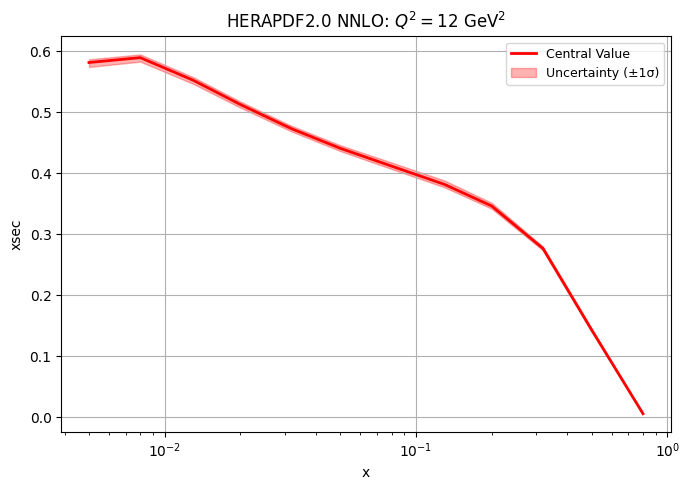

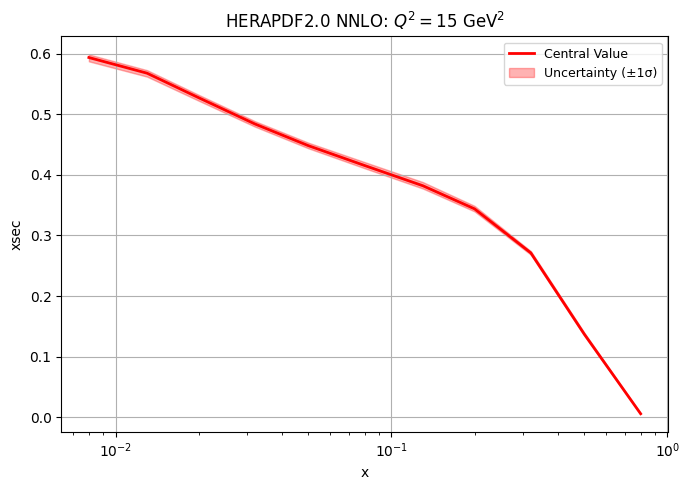

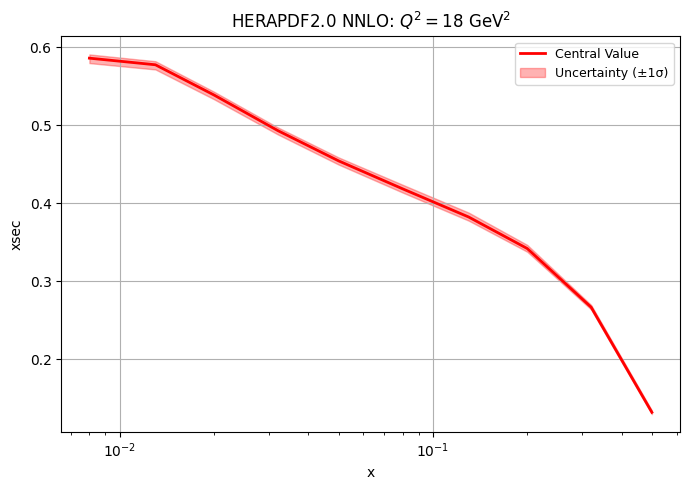

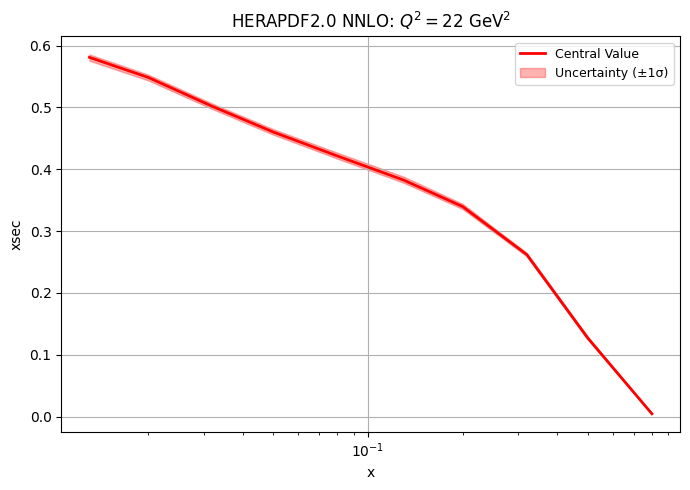

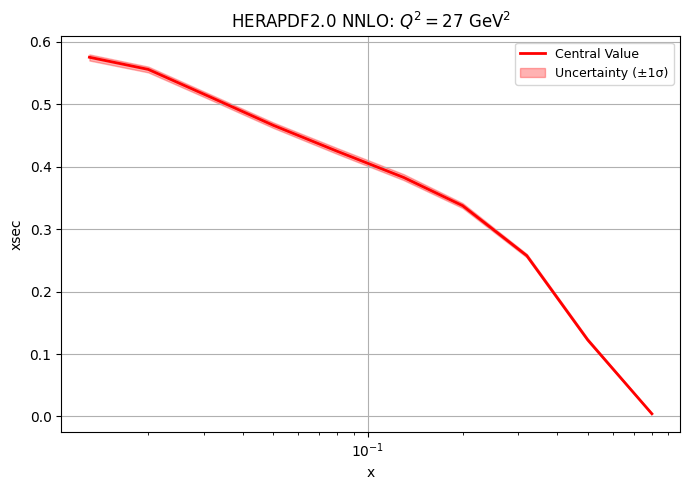

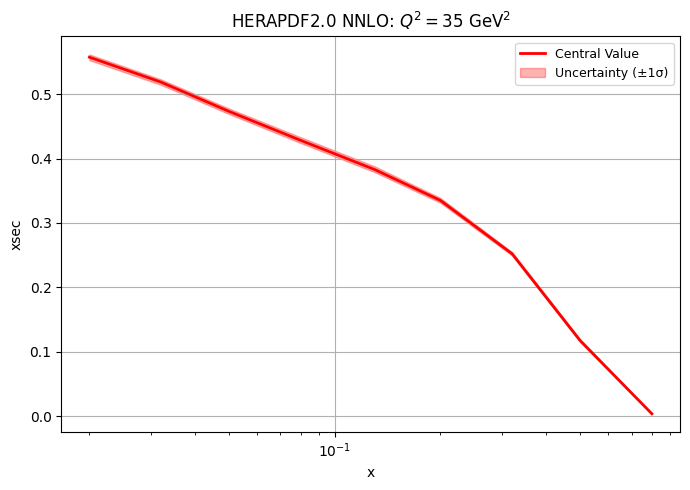

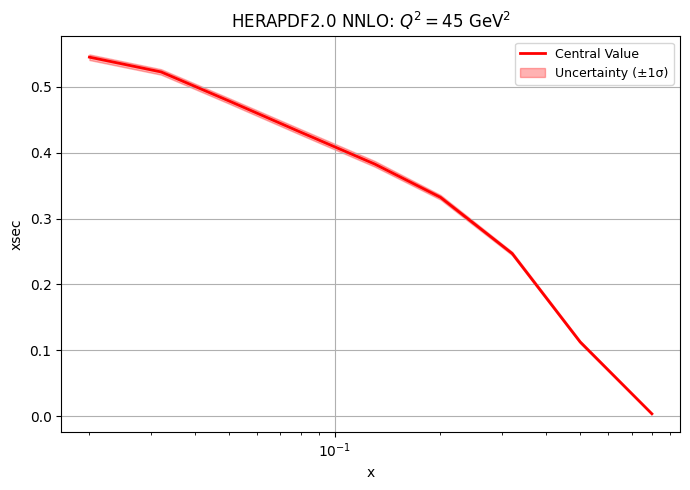

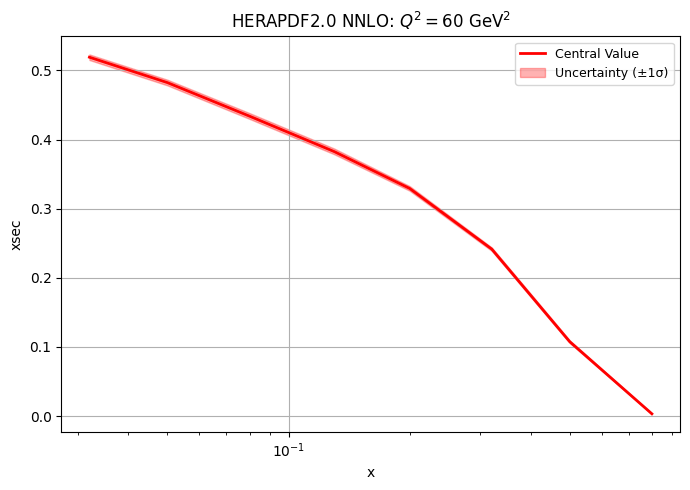

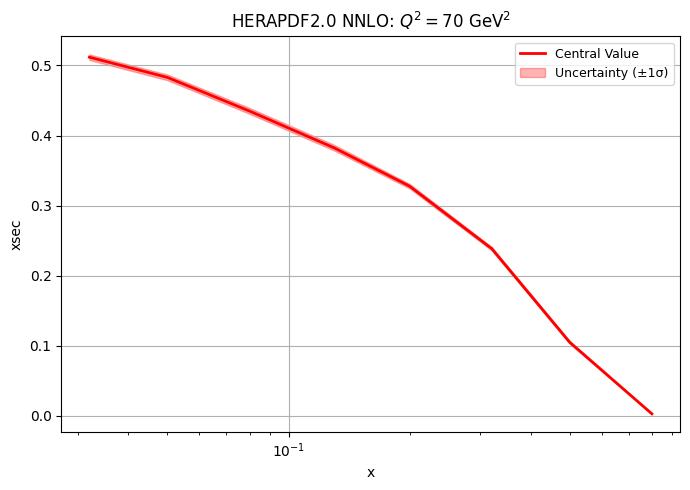

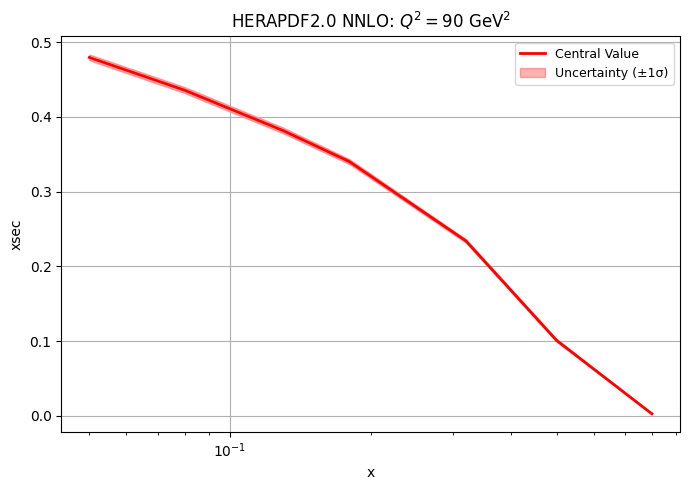

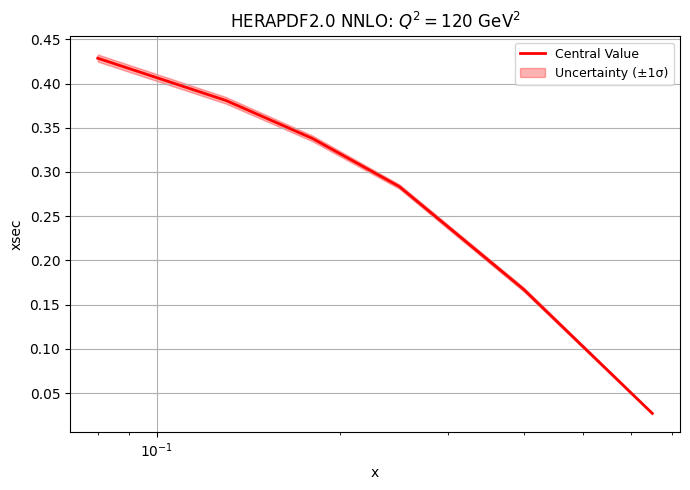

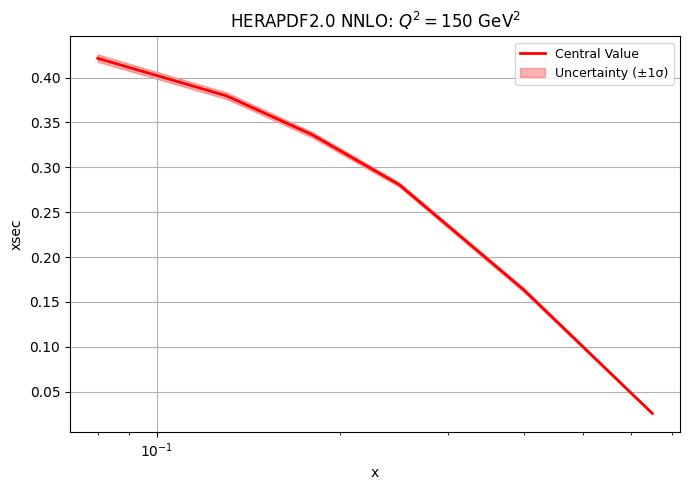

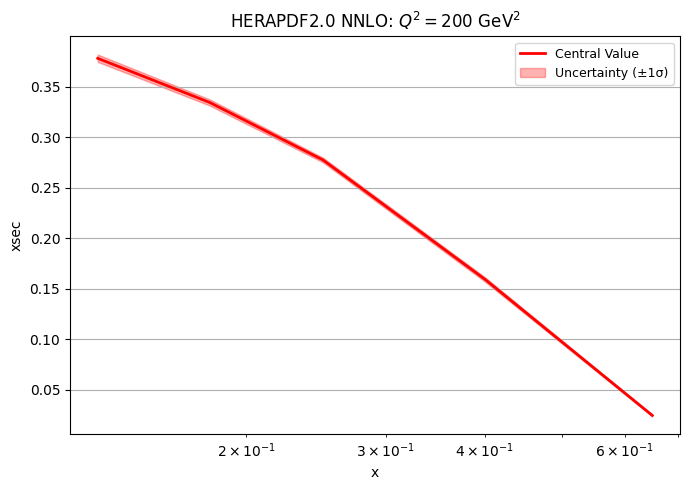

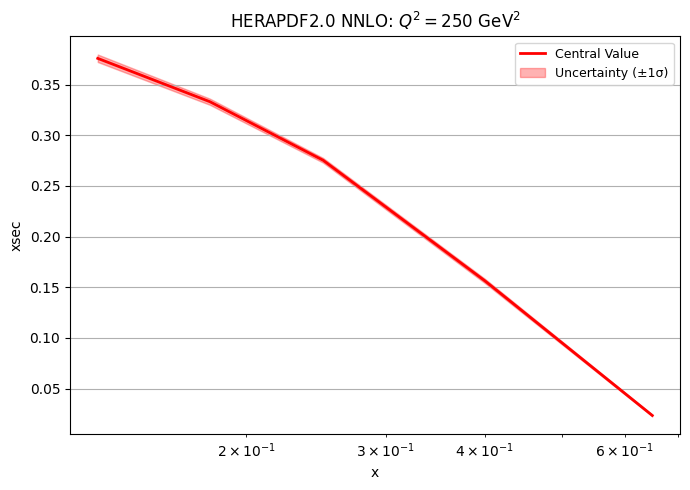

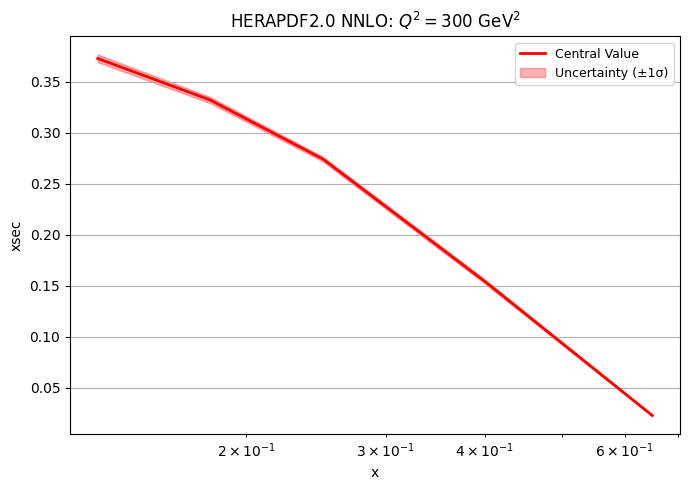

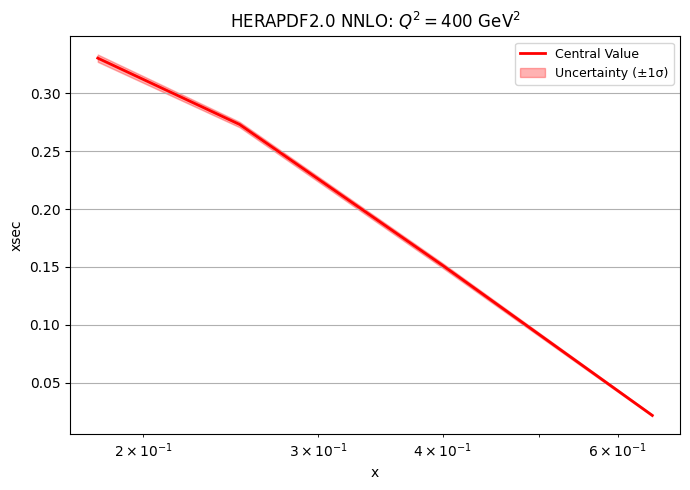

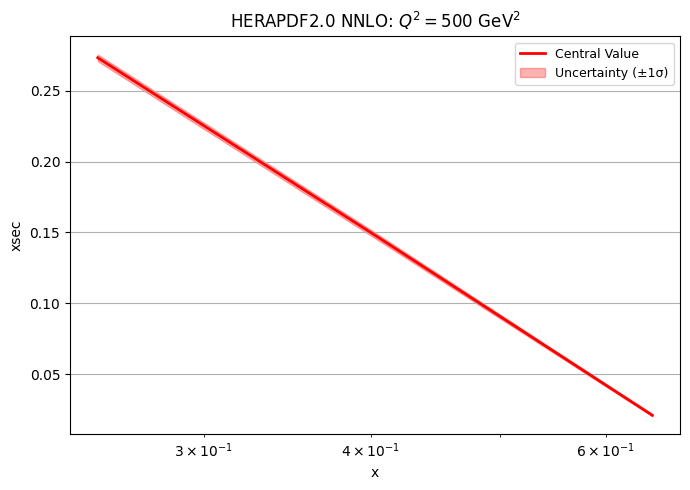

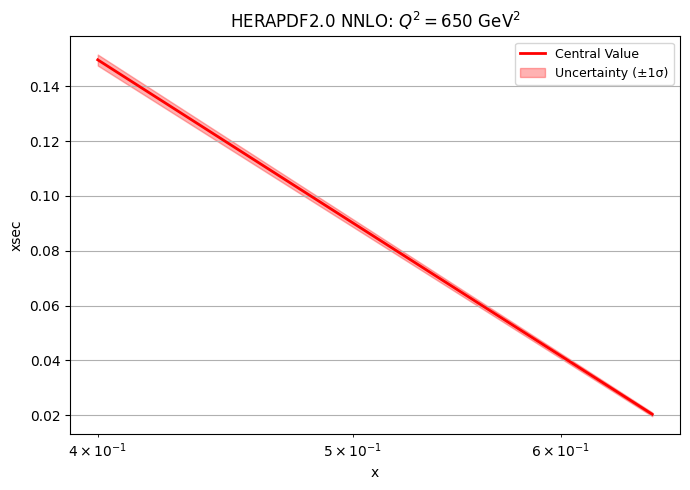

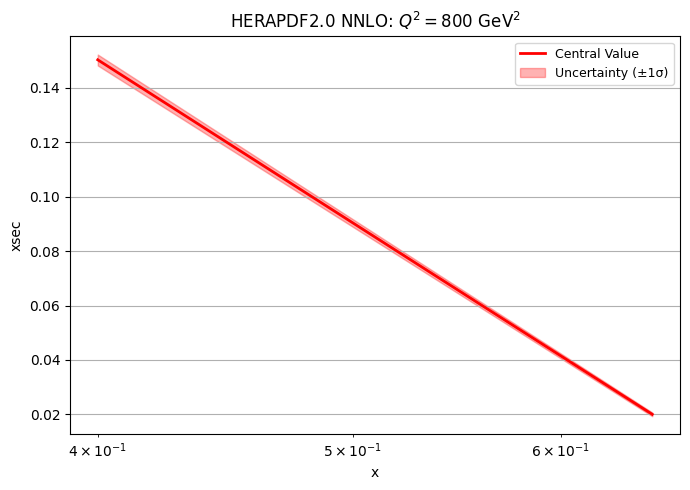

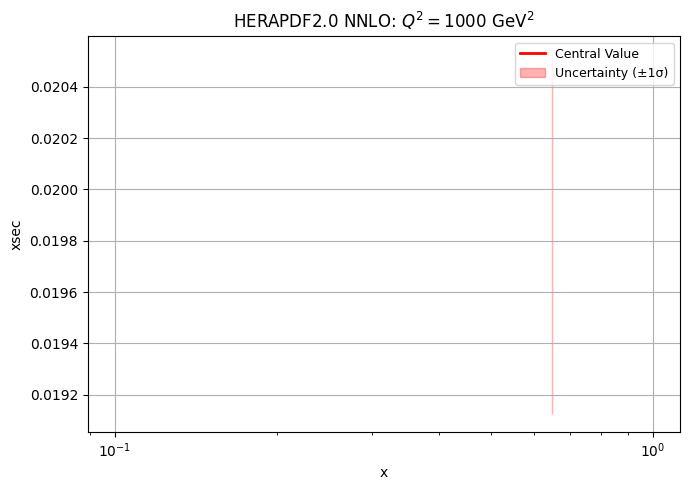

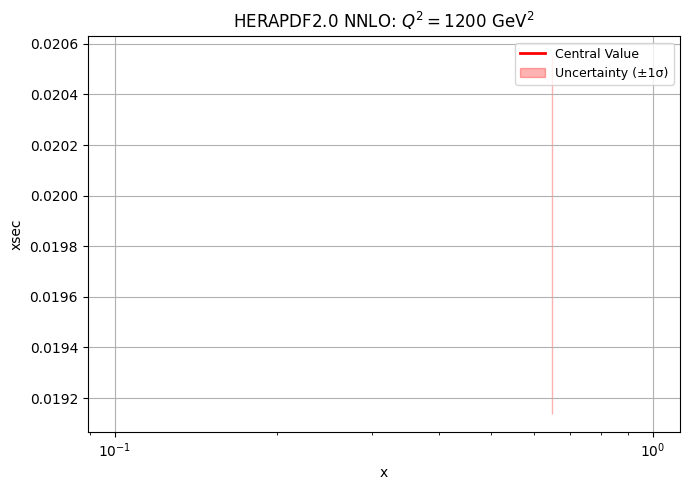

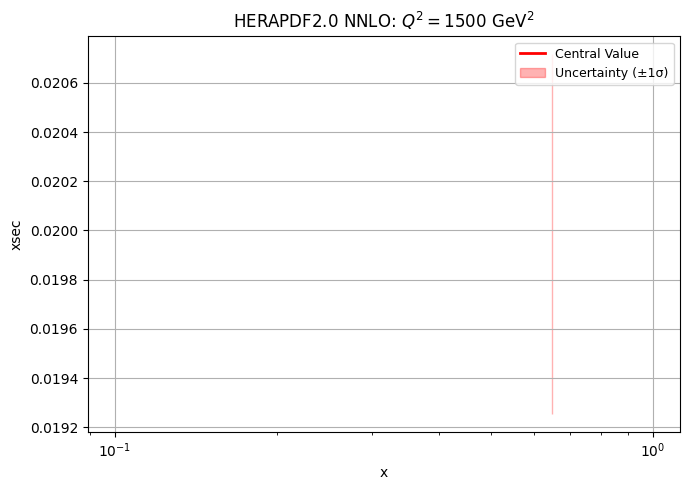

In [81]:
def plot_expectation_q2_asym(df: pd.DataFrame, q2_value: float = 139) -> None:
    """Plot central value with asymmetric uncertainty for a given Q² value."""
    fig, ax = plt.subplots(figsize=(7, 5), layout="tight")

    # Select corresponding Q2 values
    df_q2 = df[np.isclose(df['Q2'], q2_value, atol=0.01)]

    # Central value
    ax.plot(df_q2.x, df_q2["sigma_red_0"],
            label="Central Value", color="r",
            linestyle="-", linewidth=2)

    # Asymmetric uncertainty band
    lower = df_q2["sigma_red_0"] - df_q2["sigma_red_unc_-"]
    upper = df_q2["sigma_red_0"] + df_q2["sigma_red_unc_+"]

    ax.fill_between(df_q2.x, lower, upper,
                    color="r", alpha=0.3,
                    label="Uncertainty (±1σ)")

    ax.set_xlabel("x")
    ax.set_ylabel("xsec")
    ax.set_xscale("log")
    ax.set_title(f"HERAPDF2.0 NNLO: $Q^2 = {q2_value:.4g}~ \\mathrm{{GeV}}^2$")
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True)

    plt.savefig(f"../Plots/HERAPDF2.0_NNLO_Asym_Xsec_ep_Ee{eBeam}_Ep{pBeam}.{binning}_Q2_{q2_value:.4g}.png")

for Q2 in herapdf_df['Q2'].unique():
    plot_expectation_q2_asym(herapdf_df, Q2)
plt.show()